# Friends series and dialog analysis

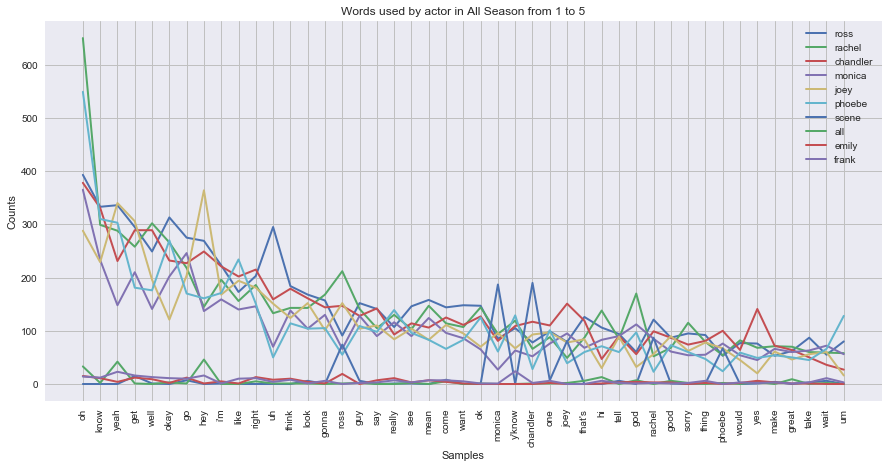

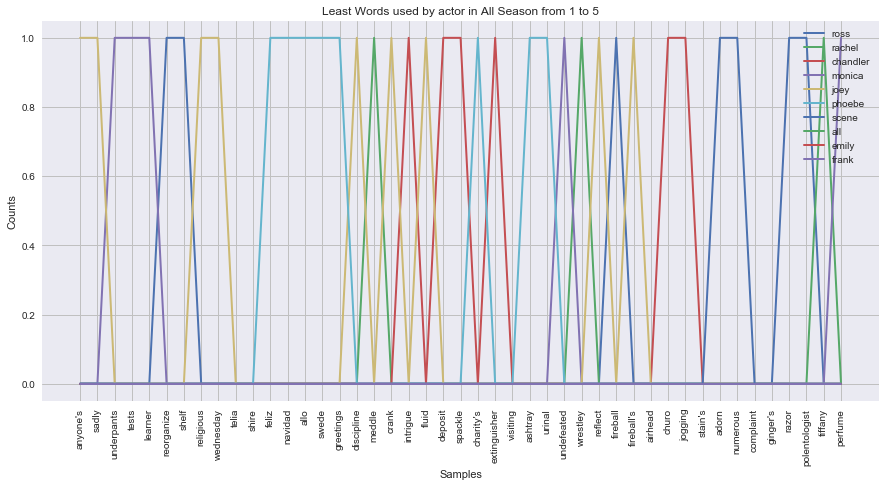

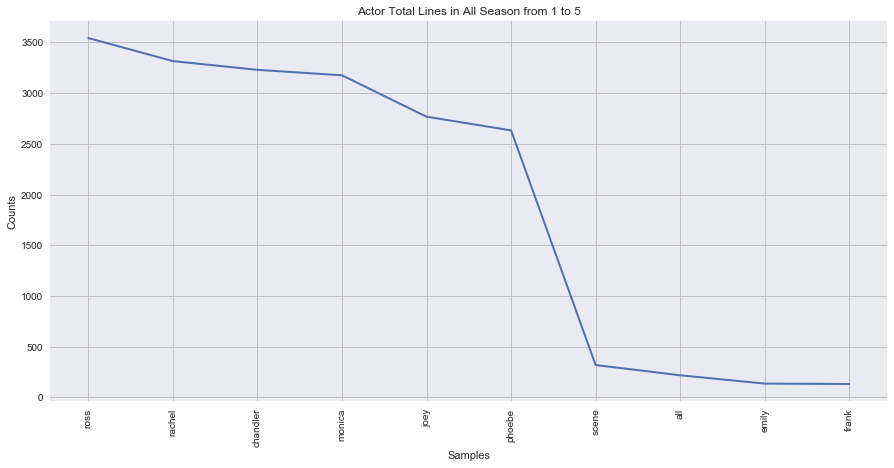

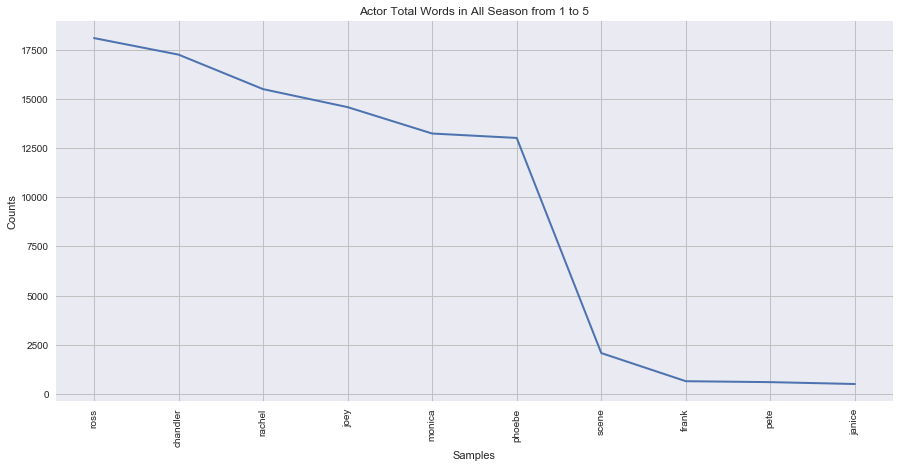

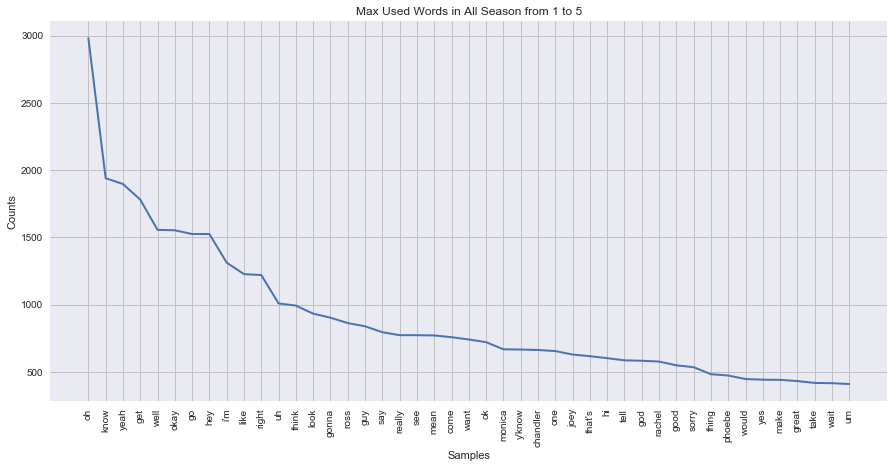

In [4]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize.simple import LineTokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import ConditionalFreqDist
from nltk.corpus import stopwords
import re
import string
from matplotlib.backends.backend_pdf import PdfPages
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder

#%matplotlib inline
sns.set()

debug = False
checkForStopWords = True
localTest = False
topNWords = 45
topNActors = 10
actorsMap = {"chan": "chandler",
                "chandler":"chandler",
                "ross": "ross",
                "joey": "joey",
                "mnca": "monica",
                "monica":"monica",
                "angl": "angela",
                "rach": "rachel",
                "rachel":"rachel",
                "phoe":"phoebe",
                "phoebe":"phoebe"
            }


# Get English stopwords and print some of them
sw = []
if checkForStopWords:
    sw = stopwords.words('english') + list(string.punctuation)

# Print Debug statements 
def debugLine(line) :
    if debug:
        print(line)

def episodeUrl(season, episode):
        return "http://friends.tktv.net/Episodes{0}/summaries/{1}.html".format(season, episode)

def seasonIndexUrl(seasonNumber):
    return "http://friends.tktv.net/Episodes{0}/".format(seasonNumber)

def getUrlText(url):
    r = requests.get(url)
    html = r.text
    soup = BeautifulSoup(html, 'html5lib')
    text = soup.get_text()
    return text

def getSeasonEpisodeTitles(indexUrl):
    text = getUrlText(indexUrl)
    linesTkn = LineTokenizer()
    episodeTitles = {}
    
    for line in linesTkn.tokenize(text):
        m = re.match(r"#(\d+)(.*)", line.strip())
        if m:
            episodeTitles[m.group(1)] = m.group(2)
    
    return episodeTitles

def allSeasonStats(start, end):
    """"
    #1. Who gets the, most dialog line?...
    #2  most words...
    #3. What is the most used word?
    #4. word frequency by actor
    """
    actorLines = nltk.FreqDist()
    actorWords = nltk.FreqDist()
    wordCount = nltk.FreqDist()
    freqDist = ConditionalFreqDist()
    for seasonNumber in range(start,end+1):
        for episode in range(len(getSeasonEpisodeTitles(seasonIndexUrl(seasonNumber)))):
            fqDist,aLines,aWords,wCount = episodeStats(episodeUrl(seasonNumber, episode))
            actorLines = actorLines + aLines
            freqDist = freqDist + fqDist
            actorWords = actorWords + aWords
            wordCount = wordCount + wCount
    return (freqDist, actorLines, actorWords, wordCount)

def seasonStats(seasonNumber):
    """"
    #1. Who gets the, most dialog line?...
    #2  most words...
    #3. What is the most used word?
    #4. word frequency by actor
    """
    actorLines = nltk.FreqDist()
    actorWords = nltk.FreqDist()
    wordCount = nltk.FreqDist()
    freqDist = ConditionalFreqDist()
    
    for episode in range(len(getSeasonEpisodeTitles(seasonIndexUrl(seasonNumber)))):
        fqDist,aLines,aWords,wCount = episodeStats(episodeUrl(seasonNumber, episode))
        actorLines = actorLines + aLines
        freqDist = freqDist + fqDist
        actorWords = actorWords + aWords
        wordCount = wordCount + wCount
    
    return (freqDist, actorLines, actorWords, wordCount)

def lemmantize(words):
    #Use Part of Speech (POS) tagging and Lemmatizing
    wordnet_lemmatizer = WordNetLemmatizer()
    taggedWord = nltk.pos_tag(words)
    wnpos = lambda e: ('a' if e[0].lower() == 'j' else e[0].lower()) if e[0].lower() in ['n', 'r', 'v'] else 'n'
    lemmedWords = []
    
    for tag in taggedWord:
        lemmWord = wordnet_lemmatizer.lemmatize(tag[0], wnpos(tag[1]))
        debugLine(tag[0] + "--" + tag[1] + "----" + lemmWord)
        lemmedWords.append(lemmWord)

    return lemmedWords


def episodeStats(url) :
    """
    Get single episode stats for passed URL
    Stats are
    freqDist - word by word count by actor
    actorLines - Count of lines by each actor 
    actorWords - Count of words by each actor
    wordCount - Total Count of each unique word used across actors
    """ 
    actorLines = nltk.FreqDist()
    actorWords = nltk.FreqDist()
    wordCount = nltk.FreqDist()
    freqDist = ConditionalFreqDist()

    # Get the script text to process.
    text= getUrlText(url)

    # Process Text and calculate stats.
    lineTokenizer = LineTokenizer()
    wordTokenizer = RegexpTokenizer(r'\w+\'*\w+|:') #TreebankWordTokenizer()
    
    lines = lineTokenizer.tokenize(text)
    for line in lines:
        debugLine("new line {0}".format(line))

        ### Remove all the text between openinf and closing brackets i.e. () and []
        line = re.sub('\(.*?\)|\[.*?\]', '', line)
        words = wordTokenizer.tokenize(line)

        if len(words) > 1 :
            # If line has an actor
            if(words[1][-1] == ':'):
                debugLine("{0} says".format(words[0]))
                
                actor = actorsMap.get(words[0].lower(), words[0].lower())
                actorLines[actor] += 1
                words = lemmantize(words)
                
                for word in words[2:]:
                    lowerCaseword = word.lower()
                    
                    if lowerCaseword not in sw:
                        #  Record Stats
                        actorWords[actor] += 1
                        wordCount[lowerCaseword] += 1
                        freqDist[actor][lowerCaseword] += 1
                    else:
                        debugLine("ignored word {0}".format(word))
            else:
                debugLine("ignoring --{0}---".format(words[0]))
        else:
            debugLine("LINE {0}".format(line))

    return (freqDist,actorLines,actorWords,wordCount)


def getAndDrawStats(statsCounter, params, statsTitle, printActorTopWord=False, saveAsPdf=False):
    from heapq import nlargest
    
    #Get Stats
    fqDist,aLines,aWords,wCount = statsCounter(*params)

    if printActorTopWord:
        for actor in fqDist.conditions():
            print("{0}'s max used word '{1}' {2} times, total {3} in {4}".format(actor,
                                                                                 fqDist[actor].max(), 
                                                                                 fqDist[actor][fqDist[actor].max()], 
                                                                                 sum(fqDist[actor].values()), 
                                                                                 statsTitle))
    #Draw in decending order of values
    topActors = nlargest(topNActors, aLines, key=aLines.get) #list(x for x, y in aLines.most_common(topNActors))
    
    fig1 = plt.figure(figsize=(15,7))
    fqDist.plot(title="Words used by actor in {0}".format(statsTitle), 
                conditions = topActors, 
                samples = nlargest(topNWords, wCount, key=wCount.get))

    fig2 = plt.figure(figsize=(15,7))
    fqDist.plot(title="Least Words used by actor in {0}".format(statsTitle),
                conditions=topActors,
                samples=list(x for x, y in wCount.most_common()[-topNWords:]))

    fig3 = plt.figure(figsize=(15,7))
    nltk.FreqDist(dict(aLines.most_common(topNActors))).plot(title="Actor Total Lines in {0}".format(statsTitle))

    fig4 = plt.figure(figsize=(15,7))
    nltk.FreqDist(dict(aWords.most_common(topNActors))).plot(title="Actor Total Words in {0}".format(statsTitle))

    fig5 = plt.figure(figsize=(15,7))
    wCount.plot(topNWords, title="Max Used Words in {0}".format(statsTitle))

    #save as PDF
    if saveAsPdf:
        pdf = PdfPages("Friends " + statsTitle + ".pdf")
        pdf.savefig( fig1 )
        pdf.savefig( fig2 )
        pdf.savefig( fig3 )
        pdf.savefig( fig4 )
        pdf.savefig( fig5 )
        pdf.close()


def getAndDrawEpisodeStats(seasonNum, episodeNum, printActorTopWord=False, saveAsPdf=False):
    getAndDrawStats(episodeStats, [episodeUrl(seasonNum, episodeNum)], "S{0}E{1}".format(seasonNum, episodeNum),  printActorTopWord, saveAsPdf)

def getAndDrawSeasonStats(seasonNumber, printActorTopWord=False, saveAsPdf=False):
    getAndDrawStats(seasonStats, [seasonNumber], "S{0}".format(seasonNumber), printActorTopWord, saveAsPdf)

def getAndDrawAllSeasonStats(startSeason, endSeason, printActorTopWord=False, saveAsPdf=False):
    getAndDrawStats(allSeasonStats, [startSeason, endSeason], "All Season from {0} to {1}".format(startSeason,endSeason), printActorTopWord, saveAsPdf)

#getAndDrawSeasonStats(3,False,False)
getAndDrawAllSeasonStats(1, 5, False, False)

